In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from src.model.reconstruction import MemAutoEncoder, DAGMM
from src.model.one_class import DeepSVDD
from src.trainer.ids import MemAEIDSTrainer, DAGMMIDSTrainer, DeepSVDDIDSTrainer
from src.datamanager.dataset import IDS2018Dataset
from pathlib import Path

In [2]:
# Setup base folder structure
dataset_path = "../../data/IDS2018/ids2018.csv"
base_path = Path("./ids2018")
base_path.mkdir(exist_ok=True)

# General arguments
batch_size = 1024
device = "cuda"
act_fn = "relu"
n_layers = 4
compression_factor = 2
lr = 1e-4
n_epochs = 200
thresh_mode = "auto"

print("arguments set")

arguments set


## Load data

In [3]:
dataset = IDS2018Dataset(path=dataset_path, pct=0.5, seed=42)
columns = dataset.columns[:-2]
partial_anomaly_labels = np.unique(dataset.labels)
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
print("data loaded with shape {}".format(dataset.shape()))

# Use Arrhythmia for testing before launching a training session on the much larger IDS2018 dataset
# from src.datamanager.dataset import ArrhythmiaDataset
# dataset = ArrhythmiaDataset(path="C:\\Users\\verdi\\Documents\\Datasets\\Arrhythmia\\3_minified\\arrhythmia_normalized.npz")
# batch_size = 8
# train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
# print("data loaded with shape {}".format(dataset.shape()))

data loaded with shape (9490582, 66)


## DeepSVDD Training

Initializing center c...


  0%|          | 12/3293 [00:00<00:50, 64.81it/s, epoch=1, loss=0.095]

Center c initialized.
Started training


100%|██████████| 3293/3293 [00:25<00:00, 128.95it/s, epoch=200, loss=0.000]


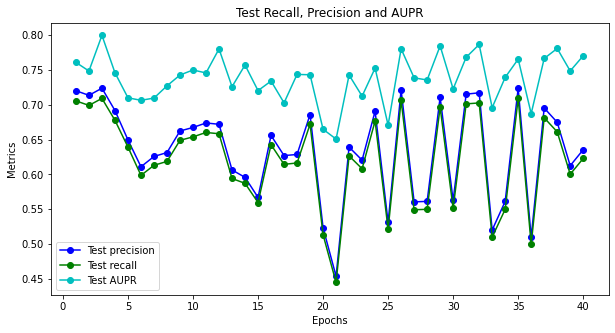

In [4]:
# Create folder structure
export_path = base_path.joinpath("deepsvdd")
ckpt_path = export_path.joinpath("checkpoint")
ckpt_path.mkdir(parents=True, exist_ok=True)

# Setup model and trainer
dsvdd_model = DeepSVDD(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_layers=n_layers,
    compression_factor=compression_factor,
    act_fn=act_fn,
)
dsvdd_trainer = DeepSVDDIDSTrainer(
    validation_ldr=test_ldr,
    model=dsvdd_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    device=device,
    ckpt_root=str(ckpt_path.absolute()),
    run_test_validation=True,
    keep_ckpt=True,
    thresh_mode=thresh_mode
)
# Train and plot validation set
dsvdd_trainer.train(train_ldr)
figname = str(export_path.absolute()) + "\\IDS2018_thresh-auto.png"
dsvdd_trainer.plot_metrics(figname=figname)

In [5]:
# Save memory
del dsvdd_trainer
del dsvdd_model

## DAGMM Training

  0%|          | 0/3293 [00:00<?, ?it/s]

Started training


100%|██████████| 3293/3293 [00:43<00:00, 75.68it/s, epoch=200, loss=8.210]


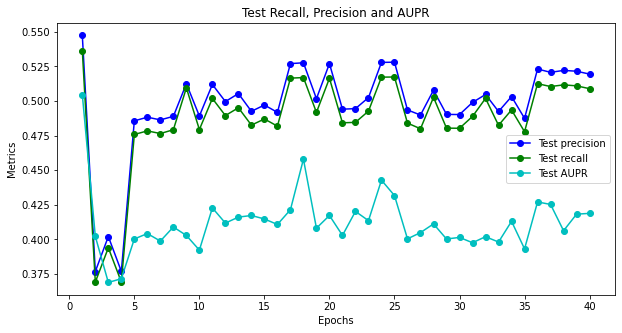

In [4]:
# Create folder structure
export_path = base_path.joinpath("dagmm")
ckpt_path = export_path.joinpath("checkpoint")
ckpt_path.mkdir(parents=True, exist_ok=True)

# Set DAGMM-specific hyperparameters
n_mixtures = 4
latent_dim = 1
lambda_1 = 0.005
lambda_2 = 0.1
reg_covar=1e-6
dagmm_best_epoch = 11

# Setup model and trainers
dagmm_model = DAGMM(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_mixtures=n_mixtures,
    latent_dim=latent_dim,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    reg_covar=reg_covar,
    n_layers=n_layers,
    compression_factor=compression_factor,
    ae_act_fn="relu",
    gmm_act_fn="relu"
)
dagmm_trainer = DAGMMIDSTrainer(
    validation_ldr=test_ldr,
    device=device,
    model=dagmm_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    ckpt_root=str(ckpt_path.absolute()),
    run_test_validation=True,
    thresh_mode=thresh_mode
)
# Train and plot validation set
dagmm_trainer.train(train_ldr)
figname = str(export_path.absolute()) + "\\IDS2018_thresh-auto.png"
dagmm_trainer.plot_metrics(figname=figname)

In [5]:
# Save memory
del dagmm_model
del dagmm_trainer

## MemAE training

  1%|          | 17/3293 [00:00<00:32, 100.92it/s, epoch=1, loss=0.751]

Started training


100%|██████████| 3293/3293 [00:33<00:00, 96.92it/s, epoch=200, loss=0.024] 


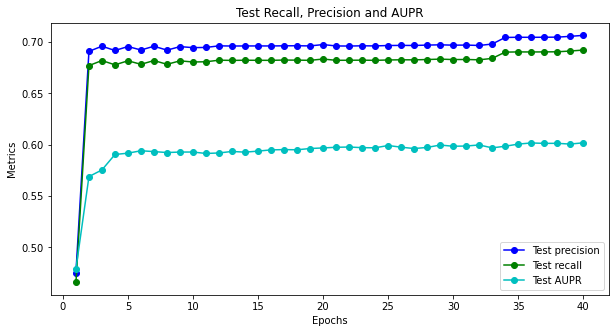

  0%|          | 14/3293 [00:00<00:36, 89.11it/s, epoch=1, loss=0.657]

Started training


100%|██████████| 3293/3293 [00:34<00:00, 96.64it/s, epoch=200, loss=0.011] 


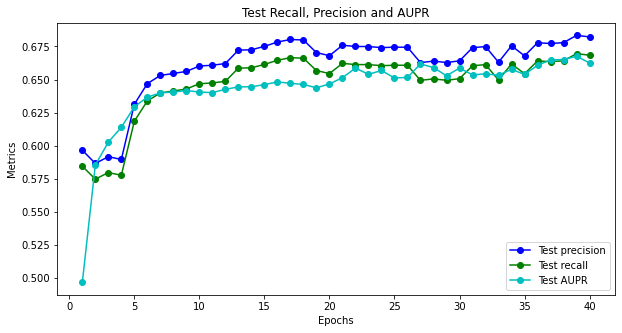

In [7]:
# Create folder structure
export_path = base_path.joinpath("memae")
ckpt_path = export_path.joinpath("checkpoint")
ckpt_path.mkdir(parents=True, exist_ok=True)

# Set MemAE-specific hyperparameters
latent_dim = 1
mem_dim = 50
shrink_thres = 0.0025
n_layers = 4
compression_factor = 2
act_fn = "relu"
alpha = 2e-4

# Setup model and trainers
memae_model = MemAutoEncoder(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    mem_dim=mem_dim,
    latent_dim=latent_dim,
    shrink_thres=shrink_thres,
    n_layers=n_layers,
    compression_factor=2,
    alpha=2e-4,
    act_fn="relu",
)
memae_trainer = MemAEIDSTrainer(
    validation_ldr=test_ldr,
    device=device,
    model=memae_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    ckpt_root=str(ckpt_path.absolute()),
    run_test_validation=True,
    keep_ckpt=True,
    thresh_mode=thresh_mode
)
# Train and plot validation set
memae_trainer.train(train_ldr)
figname = str(export_path.absolute()) + "\\IDS2018_thresh-auto.png"
memae_trainer.plot_metrics(figname=figname)

In [8]:
del memae_model
del memae_trainer